# Marginal and Joint Effects

Marginal effects measure a genetic variant's influence on a trait when considered **alone, ignoring other variants**, while joint effects measure each variant's independent contribution when all variants are **simultaneously included** in the model, revealing their true effects after **accounting for correlations (LD) between them**.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide9.png)

# Key Formula

In multiple markers linear regression, we extend the single marker model to incorporate multiple genetic variants:

$$
\mathbf{Y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

Where:
- $\mathbf{Y}$ is the $N \times 1$ vector of trait values for $N$ individuals
- $\mathbf{X}$ is the $N \times M$ matrix of genotypes for $M$ variants across $N$ individuals
- $\boldsymbol{\beta}$ is the $M \times 1$ vector of effect sizes for each variant (to be estimated)
- $\boldsymbol{\epsilon}$ is the $N \times 1$ vector of error terms for $N$ individuals and $\boldsymbol{\epsilon} \sim N(0, \sigma^2\mathbf{I})$

We can still use **ordinary least squares (OLS)** to derive the estimators for $\boldsymbol{\beta}$ in matrix form:

$$
\hat{\boldsymbol{\beta}}_{\text{OLS}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$


# Technical Details

## Marginal Effect
In [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html), we discuss the single marker linear regression, which actually estimates the marginal effect of each genetic variant, considering each variant can be treated independently.

The marginal effect of a genetic variant is its association with the trait when analyzed in isolation, without accounting for other variants:

$$
\hat{\beta}_{\text{marginal},j} = (\mathbf{X}_j^T\mathbf{X}_j)^{-1}\mathbf{X}_j^T\mathbf{Y}
$$

Where $\mathbf{X}_j$ is the column vector for the $j$-th variant.

## Joint Effect
The joint effect of a genetic variant is its association with the trait when **analyzed simultaneously with other variants**, i.e., in the multiple markers model:

$$
\hat{\boldsymbol{\beta}}_{\text{joint}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$

Where $\hat{\beta}_{\text{joint},j}$ (the $j$-th element of $\hat{\boldsymbol{\beta}}_{\text{joint}}$) represents the effect of the $j$-th variant after accounting for all other variants in the model.

## Key Differences Between Marginal and Joint Effects

- **Correlation Structure**: 
   - Marginal effects ignore correlations (linkage disequilibrium) between variants
   - Joint effects account for correlations between variants

- **Interpretation**:
   - Marginal effect: The expected change in the trait associated with a unit change in the variant, not accounting for other variants
   - Joint effect: The expected change in the trait associated with a unit change in the variant, holding all other variants constant

- **Consistency**:
   - When variants are uncorrelated, marginal and joint effects are identical
   - When variants are correlated, marginal and joint effects will differ
   - Joint effects can be smaller or larger than marginal effects, or even have opposite signs

# Related Topics

- [ordinary least squares](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html)
- [LD](https://gaow.github.io/statgen-prerequisites/linkage_disequilibrium.html)
- [confounder](https://gaow.github.io/statgen-prerequisites/confounder.html)

# Example

## Example 1 -- Causal Variant Identification with LD

When testing genetic variants individually, we might find that multiple variants appear to be associated with a trait. But what happens when we test them together? This example shows how linkage disequilibrium (correlation between nearby variants) can make non-causal variants appear significant in marginal analysis, while joint analysis reveals which variant is truly driving the association.

The key question: Which genetic variants are truly causal versus just correlated with the causal variant?

In [35]:
# Clear the environment
rm(list = ls())
set.seed(9)  # For reproducibility

# Define genotypes for 10 individuals at 3 variants
# Create correlated genotypes to simulate linkage disequilibrium
N = 20
M = 3

# Generate correlated genotype data
# Variant 1 is the true causal variant
# Variants 2 and 3 are in LD with variant 1
variant1 <- sample(0:2, N, replace = TRUE, prob = c(0.4, 0.4, 0.2))

# Create LD: variants 2 and 3 are correlated with variant 1
variant2 <- ifelse(runif(N) < 0.9, variant1, sample(0:2, N, replace = TRUE))
variant3 <- ifelse(runif(N) < 0.8, variant1, sample(0:2, N, replace = TRUE))

# Combine into matrix
Xraw_additive <- cbind(variant1, variant2, variant3)
rownames(Xraw_additive) <- paste("Individual", 1:N)
colnames(Xraw_additive) <- paste("Variant", 1:M)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# Generate phenotype where only Variant 1 has a true causal effect
true_beta1 <- 1.5  # Strong effect for variant 1
epsilon <- rnorm(N, mean = 0, sd = 0.5)
Y_raw <- X[, 1] * true_beta1 + epsilon  # Only variant 1 affects the trait

# Standardize phenotype
Y <- scale(Y_raw)

We first recall how we calculate the marginal effect of each variant in [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html):

In [36]:
# Calculate marginal effects (one SNP at a time)
p_values <- numeric(M)  # Store p-values
betas <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value and effect size (coefficient)
  p_values[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
}

marginal_OLS_results <- data.frame(
  Variant = colnames(X), 
  Beta = round(betas, 4), 
  P_Value = round(p_values, 4),
  Significant = p_values < 0.05
)


Now let's calculate the joint effects by including all variants in one model:

In [38]:
# Multiple regression model including all variants simultaneously
joint_model <- lm(Y ~ X)
joint_summary <- summary(joint_model)

# Extract the joint effect coefficients and p-values
# Skip the intercept (first row)
joint_betas <- joint_summary$coefficients[2:(M+1), 1]
joint_p_values <- joint_summary$coefficients[2:(M+1), 4]

# Create results table for joint effects
joint_OLS_results <- data.frame(
  Variant = colnames(X),
  Beta = round(joint_betas, 4),
  P_Value = round(joint_p_values, 4),
  Significant = joint_p_values < 0.05
)


In [39]:
print("Marginal Effect:")
marginal_OLS_results
print("Joint Effect:")
joint_OLS_results

[1] "Marginal Effect:"


Variant,Beta,P_Value,Significant
<chr>,<dbl>,<dbl>,<lgl>
Variant 1,0.9416,0.0000,TRUE
Variant 2,0.4997,0.0249,TRUE
Variant 3,0.8226,0.0000,TRUE


[1] "Joint Effect:"


,Variant,Beta,P_Value,Significant
,<chr>,<dbl>,<dbl>,<lgl>
XVariant 1,Variant 1,1.0253,0.0001,TRUE
XVariant 2,Variant 2,0.0757,0.4226,FALSE
XVariant 3,Variant 3,-0.1323,0.4886,FALSE


## Example 2 -- Simpson's Paradox

Sometimes a genetic variant can appear **protective** when analyzed alone, but turn out to be **harmful** when we account for other factors. This counterintuitive phenomenon is Simpson's paradox - where the direction of association completely reverses between marginal and joint analysis.

The key question: *How can a genetic variant seem protective overall but actually increase risk when we control for confounding factors?*


We'll simulate a scenario where genetic ancestry acts as a confounder:

In [12]:
rm(list = ls())
set.seed(9)  # For reproducibility

N <- 100  # Sample size

# Create a confounding variable (genetic ancestry)
ancestry <- rbinom(N, 1, 0.5)  # 0 = Population A, 1 = Population B

Different populations have different allele frequencies and Population B has much higher frequency of the "risk" allele.

In [17]:
# Generate genotype that's correlated with ancestry
# Population B has higher frequency of risk allele
variant1 <- ifelse(ancestry == 0, 
                  rbinom(sum(ancestry == 0), 2, 0.2),  # Pop A: low risk allele frequency
                  rbinom(sum(ancestry == 1), 2, 0.8))  # Pop B: high risk allele frequency

# Check allele frequencies by population
cat("Population A (ancestry=0) mean genotype:", round(mean(variant1[ancestry == 0]), 2), "\n")
cat("Population B (ancestry=1) mean genotype:", round(mean(variant1[ancestry == 1]), 2), "\n")

Population A (ancestry=0) mean genotype: 0.33 
Population B (ancestry=1) mean genotype: 1.57 


Then we generate the disease status where despite having more risk alleles, Population B has much lower disease rates overall.

In [18]:
# Population B has generally lower disease risk (better healthcare/environment)
# But the variant increases risk within each population
baseline_risk <- ifelse(ancestry == 0, 0.8, 0.1)  # Pop A much higher baseline risk
genetic_effect <- 0.1 * variant1  # Variant increases risk in both populations

disease_prob <- baseline_risk + genetic_effect
disease <- rbinom(N, 1, pmin(disease_prob, 1))  # Ensure prob ≤ 1

# Create data frame
data <- data.frame(
  disease = disease,
  variant1 = variant1,
  ancestry = ancestry
)

# Check disease rates by population
cat("Population A disease rate:", round(mean(data$disease[data$ancestry == 0]), 2), "\n")
cat("Population B disease rate:", round(mean(data$disease[data$ancestry == 1]), 2), "\n")

Population A disease rate: 0.8 
Population B disease rate: 0.24 


First, let's see what happens when we analyze each population separately:

In [25]:
# Separate data by ancestry
data_ancestry0 <- data[data$ancestry == 0, ]  # Population A
data_ancestry1 <- data[data$ancestry == 1, ]  # Population B

# Marginal analysis for Population A
marginal_model_A <- glm(disease ~ variant1, data = data_ancestry0, family = binomial)
marginal_OR_A <- exp(coef(marginal_model_A)[2])

# Marginal analysis for Population B  
marginal_model_B <- glm(disease ~ variant1, data = data_ancestry1, family = binomial)
marginal_OR_B <- exp(coef(marginal_model_B)[2])

cat("=== WITHIN-POPULATION EFFECTS ===\n")
cat("Population A: OR =", round(marginal_OR_A, 3), "\n")
cat("Population B: OR =", round(marginal_OR_B, 3), "\n")

=== WITHIN-POPULATION EFFECTS ===
Population A: OR = 1.365 
Population B: OR = 2.271 


Then we analyze the data with two ancestries combined:

In [27]:
# Marginal analysis (ignoring ancestry - combining both populations)
marginal_model <- glm(disease ~ variant1, data = data, family = binomial)
marginal_OR <- exp(coef(marginal_model)[2])
marginal_p <- summary(marginal_model)$coefficients[2, 4]

cat("=== MARGINAL EFFECT (combining populations, ignoring ancestry) ===\n")
cat("OR =", round(marginal_OR, 3), ", p =", round(marginal_p, 4), "\n")
cat("Interpretation:", ifelse(marginal_OR > 1, "Harmful", "Protective"), "\n")

=== MARGINAL EFFECT (combining populations, ignoring ancestry) ===
OR = 0.379 , p = 5e-04 
Interpretation: Protective 


 Even though the variant is harmful in both populations, it appears protective when we ignore ancestry!

Why this happens?

1. **Population B** has higher frequency of risk alleles BUT lower baseline disease risk
2. **Population A** has lower frequency of risk alleles BUT higher baseline disease risk  
3. **Marginally:** The variant appears protective because it's more common in the healthier population
4. **Within each population:** The variant actually increases disease risk

# Supplementary

## Graphical Summary

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


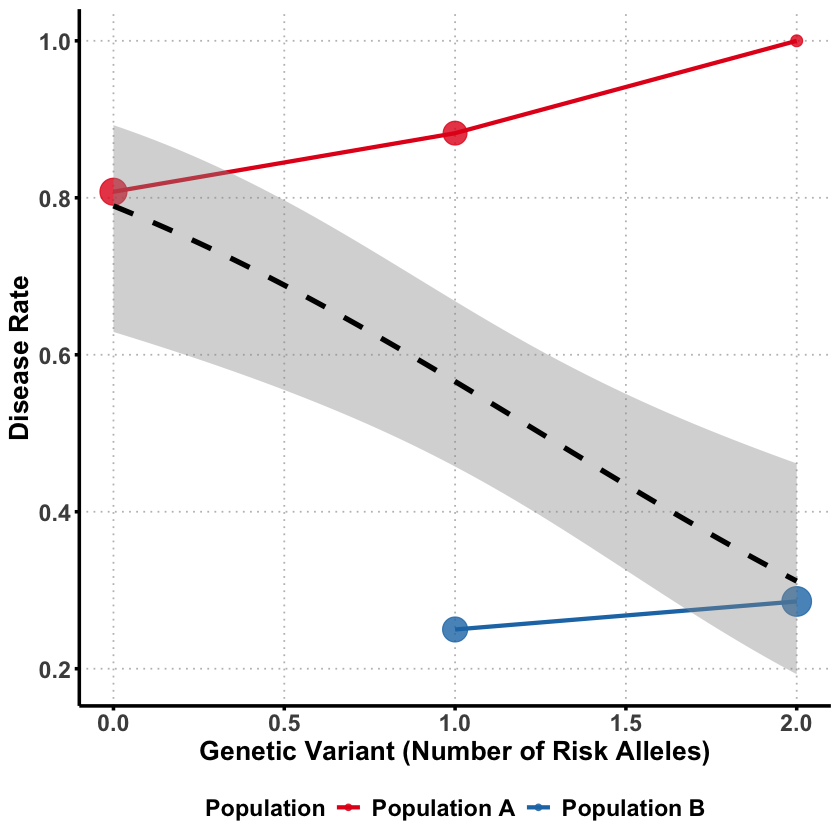

In [37]:
library(ggplot2)
library(dplyr)

# Use the same data from our example
set.seed(42)
N <- 100
ancestry <- rbinom(N, 1, 0.5)
variant1 <- ifelse(ancestry == 0, 
                  rbinom(sum(ancestry == 0), 2, 0.2),
                  rbinom(sum(ancestry == 1), 2, 0.8))
baseline_risk <- ifelse(ancestry == 0, 0.8, 0.1)
genetic_effect <- 0.1 * variant1
disease_prob <- baseline_risk + genetic_effect
disease <- rbinom(N, 1, pmin(disease_prob, 1))

# Create data frame with proper labels
plot_data <- data.frame(
  variant = variant1,
  disease = disease,
  ancestry = factor(ancestry, levels = c(0, 1), labels = c("Population A", "Population B"))
)

# Calculate summary statistics for each group
summary_stats <- plot_data %>%
  group_by(ancestry, variant) %>%
  summarise(
    disease_rate = mean(disease),
    n = n(),
    .groups = 'drop'
  )

# Create the plot
p <- ggplot(summary_stats, aes(x = variant, y = disease_rate)) +
  # Points for each ancestry group
  geom_point(aes(color = ancestry, size = n), alpha = 0.8) +
  geom_line(aes(color = ancestry, group = ancestry), linewidth = 1.2) +
  
  # Overall trend line (ignoring ancestry)
  geom_smooth(data = plot_data, aes(x = variant, y = disease), 
              method = "glm", method.args = list(family = "binomial"),
              se = TRUE, color = "black", linetype = "dashed", linewidth = 1.5) +
  
  scale_color_manual(values = c("Population A" = "#E31A1C", "Population B" = "#1F78B4")) +
  scale_size_continuous(range = c(3, 8), guide = "none") +
  
  labs(
    x = "Genetic Variant (Number of Risk Alleles)",
    y = "Disease Rate",
    color = "Population"
      ) +
  
  theme_minimal() +
  theme(
    text = element_text(size = 14, face = "bold"),
    plot.title = element_blank(),
    axis.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 14, face = "bold"),
    legend.position = "bottom",  # Position legend at the bottom
    panel.grid.major = element_line(color = "gray", linetype = "dotted"),
    panel.grid.minor = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(size = 1),
    # Add transparent backgrounds
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  ) 
# Display the plot
print(p)

# Save with transparent background
ggsave("./cartoons/marginal_joint_effects.png", plot = p, 
       width = 8, height = 8, 
       bg = "transparent", 
       dpi = 300)